In [37]:
import pandas as pd
import requests
import json
import numpy as np

In [38]:
def getQuestions():
    curr_url_quiz = 'https://www.jsonkeeper.com/b/LLQT'
    curr_quiz_data = requests.get(curr_url_quiz).json()['quiz']
    

    questions = curr_quiz_data['questions']
    questions = pd.DataFrame(questions)

    optdf = pd.DataFrame(questions.options.to_list(), columns=['op1', 'op2', 'op3', 'op4'])
    optdf = pd.concat([pd.json_normalize(optdf[col]).add_prefix(f'{col}_') for col in optdf.columns], axis=1)
    req_cols = ['id', 'difficulty_level', 'topic', 'type', 'pyq_label', 'topic_id', 'quiz_level', 'tag',
                'op1_id', 'op1_is_correct','op2_id', 'op2_is_correct' ,'op3_id', 'op3_is_correct', 'op4_id', 'op4_is_correct']

    df = pd.merge(questions, optdf, left_on='id', right_on='op1_question_id', how='inner')[req_cols]
    df['difficulty_level'] = ['Not Defined' if lev is None else lev for lev in df['difficulty_level']]
    return df
questions = getQuestions()
questions.head()

,id,difficulty_level,topic,type,pyq_label,topic_id,quiz_level,tag,op1_id,op1_is_correct,op2_id,op2_is_correct,op3_id,op3_is_correct,op4_id,op4_is_correct
0,1827,Not Defined,structural organisation in animals,,None,146,None,,7321,False,7322,False,7323,True,7324,False
1,1828,Not Defined,structural organisation in animals,,None,146,None,,7325,False,7326,False,7327,False,7328,True
2,1829,Not Defined,structural organisation in animals,,None,146,None,,7329,False,7330,True,7331,False,7332,False
3,1830,Not Defined,structural organisation in animals,,None,146,None,,7333,False,7334,False,7335,False,7336,True
4,1831,Not Defined,structural organisation in animals,,None,146,None,,7337,False,7338,False,7339,False,7340,True


In [39]:
response_url = 'https://api.jsonserve.com/rJvd7g'
response_data = requests.get(response_url).json()

response_data

{'id': 336566,
 'quiz_id': 43,
 'user_id': '7ZXdz3zHuNcdg9agb5YpaOGLQqw2',
 'submitted_at': '2025-01-17T15:51:29.859+05:30',
 'created_at': '2025-01-17T15:51:29.871+05:30',
 'updated_at': '2025-01-17T15:51:29.871+05:30',
 'score': 32,
 'trophy_level': 2,
 'accuracy': '80 %',
 'speed': '100',
 'final_score': '30.0',
 'negative_score': '2.0',
 'correct_answers': 8,
 'incorrect_answers': 2,
 'source': 'live',
 'type': 'topic',
 'started_at': '2025-01-17T16:20:44.000+05:30',
 'ended_at': '2025-01-17T16:21:28.000+05:30',
 'duration': '15:00',
 'better_than': 24,
 'total_questions': 128,
 'rank_text': 'Topic Rank - #2402',
 'mistakes_corrected': 6,
 'initial_mistake_count': 8,
 'response_map': {'1837': 7363,
  '1848': 7407,
  '1852': 7423,
  '1862': 7464,
  '1877': 7525,
  '1878': 7529,
  '1900': 7617,
  '1917': 7685,
  '1934': 7750,
  '1964': 7872},
 'quiz': {'id': 43,
  'name': None,
  'title': 'Structural Organisation in Animals and Plants (7)',
  'description': '',
  'difficulty_level': 

In [40]:
response_data.keys()

dict_keys(['id', 'quiz_id', 'user_id', 'submitted_at', 'created_at', 'updated_at', 'score', 'trophy_level', 'accuracy', 'speed', 'final_score', 'negative_score', 'correct_answers', 'incorrect_answers', 'source', 'type', 'started_at', 'ended_at', 'duration', 'better_than', 'total_questions', 'rank_text', 'mistakes_corrected', 'initial_mistake_count', 'response_map', 'quiz', 'next_steps'])

In [41]:
resp_map = pd.DataFrame(list(response_data['response_map'].items()), columns=['q_id', 'op_id'])
resp_map['op_id'] = resp_map['op_id'].astype('int16')
resp_map['q_id'] = resp_map['q_id'].astype('int16')

resp_map

,q_id,op_id
0,1837,7363
1,1848,7407
2,1852,7423
3,1862,7464
4,1877,7525
5,1878,7529
6,1900,7617
7,1917,7685
8,1934,7750
9,1964,7872


### Seprating the question_ids as per the option selected

In [42]:
correct_ques, wrong_ques = [], []

for x in resp_map.index:
    q_id = resp_map.loc[x].q_id
    op_id = resp_map.loc[x].op_id

    # getting the data of the question
    que = questions[questions.id == q_id]

    # for all the options in the question
    for i in range(1, 5):
        id_col, corr_col = f'op{i}_id', f'op{i}_is_correct'
        if que.iloc[0][id_col] == op_id:
            if que.iloc[0][corr_col]:
                correct_ques.append(q_id)
            else:
                wrong_ques.append(q_id)    

In [43]:
len(correct_ques), len(wrong_ques)

(8, 2)

### Making Visualizations

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
labels = ['Correct Questions', 'Wrong Questions']
values = [len(correct_ques), len(wrong_ques)]

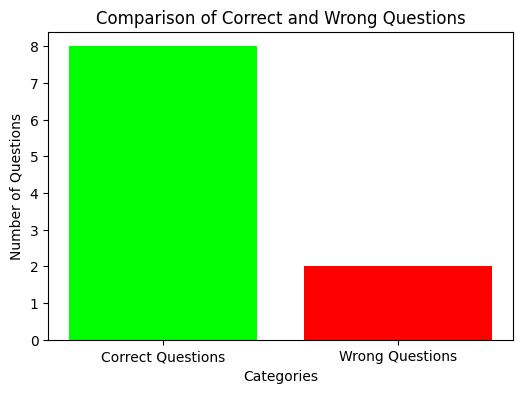

In [46]:
plt.figure(figsize=(6,4))
plt.bar(labels, values, color=['#00ff00', '#ff0000'])
plt.xlabel('Categories')
plt.ylabel('Number of Questions')
plt.title('Comparison of Correct and Wrong Questions')

plt.savefig('images/correct_vs_wrong_bar.png')


### Gettinng the topics and difficulty of the questions

In [47]:
def getTopics(lst):
    df = questions[questions.id.isin(lst)]
    topic_df = df.groupby('topic')['id'].count().sort_values(ascending=False)
    diffculty_df = df.groupby('difficulty_level')['id'].count().sort_values(ascending=False)

    return topic_df, diffculty_df

In [48]:
topic_df_corr, diffculty_df_corr = getTopics(correct_ques)
topic_df_wrn, diffculty_df_wrn = getTopics(wrong_ques)

In [49]:
topic_df_combined = pd.concat([topic_df_corr, topic_df_wrn], axis = 1, keys = ['Correct', 'Worng'])
topic_df_combined = topic_df_combined.reset_index()
diffculty_df_combined = pd.concat([diffculty_df_corr, diffculty_df_wrn], axis = 1, keys = ['Correct', 'Worng'])
diffculty_df_combined = diffculty_df_combined.reset_index()


In [50]:
topic_df_combined.columns = ['topic', 'Correct', 'Wrong']
df_long_topic = pd.melt(topic_df_combined, id_vars=['topic'], value_vars=['Correct', 'Wrong'], 
                  var_name='Category', value_name='Count')

diffculty_df_combined.columns = ['difficulty_level', 'Correct', 'Wrong']
diffculty_df_combined = pd.melt(diffculty_df_combined, id_vars=['difficulty_level'], value_vars=['Correct', 'Wrong'], 
                  var_name='Category', value_name='Count')

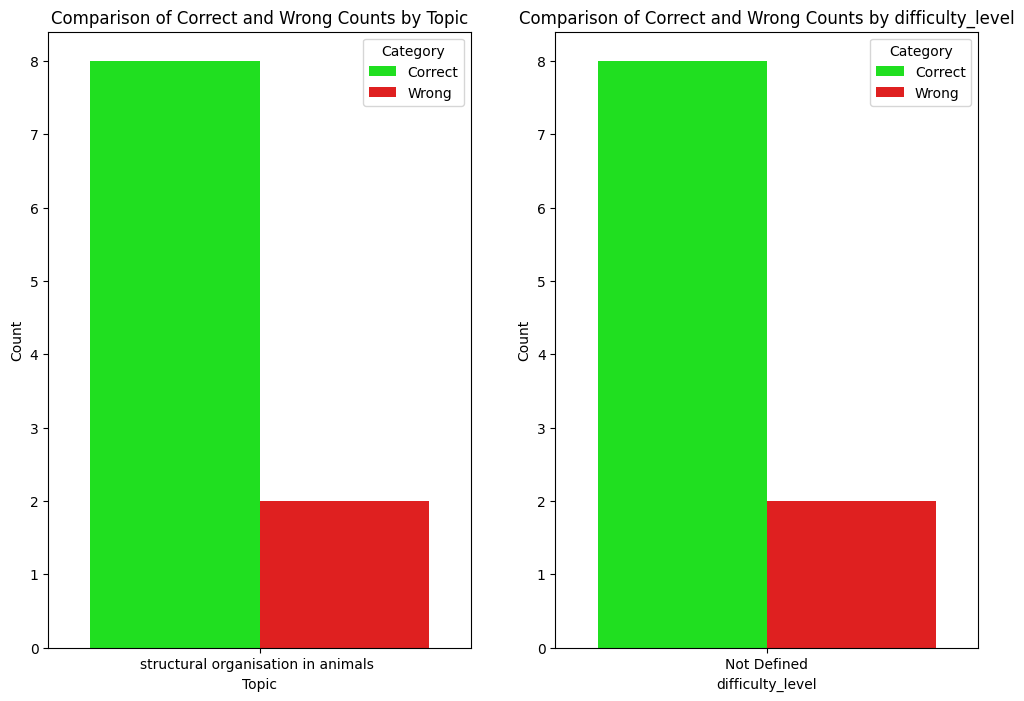

In [52]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.barplot(x='topic', y='Count', hue='Category', data=df_long_topic, palette=['#00ff00', '#ff0000'])

plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Comparison of Correct and Wrong Counts by Topic')


plt.subplot(1,2,2)
sns.barplot(x='difficulty_level', y='Count', hue='Category', data=diffculty_df_combined, palette=['#00ff00', '#ff0000'])

plt.xlabel('difficulty_level')
plt.ylabel('Count')
plt.title('Comparison of Correct and Wrong Counts by difficulty_level')

plt.savefig('images/topic_and_difficulty_comp.png')

In [53]:
diffculty_df_combined

,difficulty_level,Category,Count
0,Not Defined,Correct,8
1,Not Defined,Wrong,2
